In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
#from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, mean_squared_error
from modelling_functions import *

## Processing for Models

In [2]:
#### Read Data files
dict_dictonary = {}
housing, housing_features, feat_labels, dict_dictonary = read_and_clean(filepath = "../data/train_selected_features.csv")

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


C:\Users\Olympus\Project\machina_ex_kaggle\modelling\modelling_functions.py:110: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  housing.col, id_dictonary = to_numeric(housing, col, 'SalePrice')


In [3]:
htest_id, htest_features, htest_labels, htest_dictonary = read_and_clean(filepath = "../data/test_selected_features.csv", test = True, dictonary = dict_dictonary)

MSZoning **************************************************
['C (all)', 'Othr', 'RL', 'FV']
['Othr', 'RL', 'FV', 'C (all)']
[]
{'C (all)': 0, 'Othr': 1, 'RL': 2, 'FV': 3}
['Othr' 'RL' 'FV' 'C (all)']
Street **************************************************
['Grvl', 'Pave']
['Pave', 'Grvl']
[]
{'Grvl': 0, 'Pave': 1}
['Pave' 'Grvl']
Alley **************************************************
['Grvl', 'None']
['None', 'Grvl']
[]
{'Grvl': 0, 'None': 1}
['None' 'Grvl']
LotShape **************************************************
['Reg', 'IRG']
['Reg', 'IRG']
[]
{'Reg': 0, 'IRG': 1}
['Reg' 'IRG']
LandContour **************************************************
['Bnk', 'Lvl', 'Low', 'HLS']
['Lvl', 'HLS', 'Bnk', 'Low']
[]
{'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3}
['Lvl' 'HLS' 'Bnk' 'Low']
Utilities **************************************************
['NoSeWa', 'AllPub']
['AllPub']
[]
{'NoSeWa': 0, 'AllPub': 1}
['AllPub']
LotConfig **************************************************
['NotCulD', 'CulD']

C:\Users\Olympus\Project\machina_ex_kaggle\modelling\modelling_functions.py:92: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  housing.col, id_dictonary = to_numeric_test(housing, col, dictonary)


In [5]:
housing.saleprice

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
5       11.870600
6       12.634603
7       12.206073
8       11.774520
9       11.678440
10      11.771436
11      12.751300
12      11.877569
13      12.540758
14      11.964001
15      11.790557
16      11.911702
17      11.407565
18      11.976659
19      11.842229
20      12.692503
21      11.845103
22      12.345835
23      11.774520
24      11.944708
25      12.454104
26      11.811547
27      12.631340
28      12.242887
29      11.134589
          ...    
1425    12.165980
1426    11.875831
1427    11.074421
1428    12.136187
1429    11.982929
1430    12.066811
1431    11.699405
1432    12.885671
1433    11.916389
1434    12.190959
1435    12.160029
1436    11.913713
1437    12.644328
1438    11.703546
1439    12.098487
1440    11.767568
1441    11.969717
1442    12.388394
1443    11.626254
1444    11.429544
1445    11.820410
1446    12.567551
1447    11.884489
1448    11.344507
1449    12

In [5]:
trim = ['miscfeature', 'street', 'condition2', 'utilities', 'roofmatl', 'heating',
       'roofstyle', 'bsmtcond', 'bsmtfintype2', 'x3ssnporch']

In [6]:
#trim = ['paveddrive', 'miscfeature', 'utilities', 'roofmatl', 'heating', 'street']
training = housing_features.drop(trim, axis=1)
testing = htest_features.drop(trim, axis=1)

In [6]:
training = housing_features
testing = htest_features

In [8]:
print(training.shape)
print(testing.shape)

(1455, 66)
(1459, 66)


In [9]:
htrain, htest, ptrain, ptest = train_test_split(training, housing.saleprice, test_size = 0.33)

## RandomForestRegressor

In [36]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 10000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20, 30, 40]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 16, 32, 64]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 1288, 2377, 3466, 4555, 5644, 6733, 7822, 8911, 10000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 29, 48, 67, 86, 105, 124, 143, 162, 181, 200, None], 'min_samples_split': [2, 5, 10, 15, 20, 30, 40], 'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64], 'bootstrap': [True, False]}


In [37]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(htrain, ptrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/sama/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: 

In [9]:
rf_random.best_params_

{'n_estimators': 4555,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 162,
 'bootstrap': False}

In [17]:
clf = RandomForestRegressor(n_estimators=4555, 
                            random_state=9, 
                            n_jobs=-1, 
                            min_samples_split = 2, 
                            min_samples_leaf = 1, 
                            max_features = 'sqrt', 
                            max_depth = 162,
                            bootstrap = False)
#sfm = SelectFromModel(clf, threshold = 0.01)
#sfm.fit(htrain, ptrain)
# ## Not Finished
# # Measure Feature Importance
#feature_selected = []
#for feature_list_index in sfm.get_support(indices=True):
#     feature_selected.append(feat_labels[feature_list_index])
#proxy = feature_selected
#trimmed = ['x1stflrsf', 'x2ndflrsf', 'garagecars', 'overallcond', 'saleprice', 'Unnamed: 0', 'bsmtfinsf1']
#testing = testing[proxy]
#housing_features = housing_features[trimmed_features]
#print(feature_selected)

In [18]:
clf.fit(htrain, ptrain)

clf.score(htest, ptest)

0.8562974417955274

In [19]:
nice = clf.predict(htest)
mean_squared_error(nice, ptest)

0.022411580487852308

In [140]:
pred = np.exp(clf.predict(htest_features))
Submission(htest_id, pred)

## Lasso

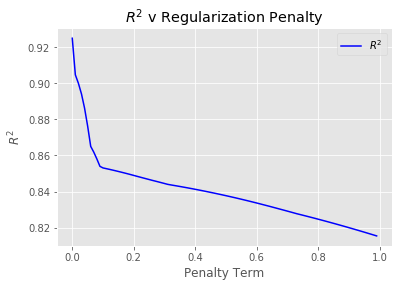

In [13]:
alp = optimize_penalty(htrain, ptrain, model=Lasso, min_=1e-7, max_=1, step=0.0001, plot=True)

In [14]:
alp.best_params_

AttributeError: 'tuple' object has no attribute 'best_params_'

In [10]:
lasso = Lasso(normalize=True)
lasso.set_params(alpha = 1e-7)
lasso.fit(htrain, ptrain)

print(lasso.score(htrain, ptrain))
print(lasso.score(htest, ptest))
#print(selected_coefs)
pred = lasso.predict(htest)

0.9215826410957992
0.8925906462144002


In [11]:
mean_squared_error(pred, ptest)

0.016079964304549214

In [31]:
testing.columns

Index(['mssubclass', 'mszoning', 'lotarea', 'street', 'alley', 'lotshape',
       'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood',
       'condition1', 'condition2', 'bldgtype', 'overallqual', 'overallcond',
       'yearbuilt', 'yearremodadd', 'roofstyle', 'roofmatl', 'exterior1st',
       'masvnrtype', 'masvnrarea', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'bsmtunfsf', 'totalbsmtsf', 'heating', 'heatingqc', 'centralair',
       'electrical', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath',
       'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr',
       'kitchenqual', 'totrmsabvgrd', 'functional', 'fireplaces',
       'fireplacequ', 'garagetype', 'garageyrblt', 'garagearea', 'paveddrive',
       'wooddecksf', 'openporchsf', 'enclosedporch', 'x3ssnporch',
       'screenporch', 'poolarea', 'fence', 'miscfeature', 'mosold', 'yrsold',
       'saletype', 'salecondition

In [32]:
htrain.columns

Index(['mssubclass', 'mszoning', 'lotarea', 'street', 'alley', 'lotshape',
       'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood',
       'condition1', 'condition2', 'bldgtype', 'overallqual', 'overallcond',
       'yearbuilt', 'yearremodadd', 'roofstyle', 'roofmatl', 'exterior1st',
       'masvnrtype', 'masvnrarea', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'bsmtunfsf', 'totalbsmtsf', 'heating', 'heatingqc', 'centralair',
       'electrical', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath',
       'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr',
       'kitchenqual', 'totrmsabvgrd', 'functional', 'fireplaces',
       'fireplacequ', 'garagetype', 'garageyrblt', 'garagearea', 'paveddrive',
       'wooddecksf', 'openporchsf', 'enclosedporch', 'x3ssnporch',
       'screenporch', 'poolarea', 'fence', 'miscfeature', 'mosold', 'yrsold',
       'saletype', 'salecondition

In [14]:
pred = (lasso.predict(testing))

In [13]:
pred[1:10]

array([42.51412387, 42.76610533, 43.14914014, 43.09026955, 42.6404297 ,
       42.8575196 , 42.63976209, 42.7198058 , 42.54812415])

In [319]:
Submission(htest_id, pred)